In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def uniform_hypersphere(d, sigma=1.):
    # sample a point uniformly from d-1 sphere
    x = np.random.randn(d)
    x /= np.linalg.norm(x)
    x *= sigma
    return x

def isotropic_gaussian(d):
    # sample a point from N(0, I_d)
    x = np.random.randn(d)
    return x

In [3]:
def y_sample(D, c, X, eps=0.):
    noise = np.random.normal(size=X.shape[0]) * eps
    y = X @ (D @ c) + noise # no noise added
    return y
def X_sample(n, d, distribution_sample, device='cpu'):
    # a n \times d matrix with each row sampled according to function distribution_sample
    X = []
    for i in range(n):
        X.append(distribution_sample(d))
    X = np.array(X)
    if device=='cuda':
        return torch.FloatTensor(X).cuda()
    return X

def c_sample(k, distribution_sample, device='cpu'):
    # a k dimensional vector sampled according to distribution_sample
    c = distribution_sample(k) 
    if device=='cuda':
        return torch.FloatTensor(c).cuda()
    return c

def add_noise(D, eps=0.0):
    return np.random.uniform(-eps, eps, size=D.shape) + D

In [4]:
def task_c_loss_gradient_with_query(X, y, D, X2=None, y2=None, lambd=0., device='cpu'):
    
    if X2 is None:
        X2 = X
        y2 = y
        
    n = X.shape[0]
    p = n
    if device == 'cuda':
        inv = torch.inverse
        outer = torch.ger
        norm = torch.norm
        I = torch.eye(p, p).cuda()
    else:
        inv = np.linalg.inv
        norm = np.linalg.norm
        outer = np.multiply.outer
        I = np.eye(p, p)
    
    # if model is over-parameterized, use Woodburry Identity 
    # ||(X2DD.TX.T*(XDD.TX.T+lambd*eye)^{-1}y-y2)||^2
#     print(X.shape, X2.shape, D.shape, y.shape, y2.shape)
    A = X @ D # n x k
    A2 = X2 @ D # n2 x k
    AT = A.T # k x n
    A2T = A2.T # k x n2

    AAT = A @ A.T # n x n
    S = inv(AAT + (lambd * I)) # T_0   # n x n

    Sy = S @ y # n x 1
    XTSy = (X.T) @ Sy # t_1 (d x 1)
    c_solved = D.T @ XTSy # k x 1

    pred = A2 @ c_solved # n2 x 1
    err = (pred - y2) # t_2 (n2 x 1)
    
    ATSy = AT @ Sy # t_3 (k x 1)
    X2Terr = X2.T @ err  # t_4 d x 1
    A2Terr = A2T @ err # t_5
    SAA2Terr = S @ (A @ A2Terr)

    functionValue = (norm(err) ** 2)
    gradient = (2 * outer(X2Terr, ATSy))\
            + (2 * outer(XTSy, A2Terr))\
            - (2 * outer(X.T @ SAA2Terr, ATSy))\
            - (2 * outer(XTSy, A.T @ SAA2Terr))


    return c_solved, functionValue / n, gradient / n

In [5]:
def task_c_loss_gradient_without_query(X, y, D, lambd=0., device='cpu'):
    
    n = X.shape[0]
    k = D.shape[1]
    p = min(n,k)
    if device == 'cuda':
        inv = torch.inverse
        outer = torch.ger
        norm = torch.norm
        I = torch.eye(p, p).cuda()
    else:
        inv = np.linalg.inv
        norm = np.linalg.norm
        outer = np.multiply.outer
        I = np.eye(p, p)
    
    # if model is over-parameterized, use Woodburry Identity 
    # ||(XDD.TX.T*(XDD.TX.T+lambd*eye)^{-1}y-y)||^2
    if n < k:
        A = X @ D # n x k
        AT = A.T # k x n
        AAT = A @ A.T # n x n
        S = inv(AAT + (lambd * I)) # T_0   # n x n
        Sy = S @ y # n x 1
        XTSy = (X.T) @ Sy # t_1 (d x 1)
        c_solved = D.T @ XTSy # k x 1
        pred = AAT @ Sy # n x 1
        err = (pred - y) # t_2 (n x 1)
        ATSy = AT @ Sy # t_3 (k x 1)
        XTerr = X.T @ err  # t_4 d x 1
        ATerr = AT @ err
        SAATerr = S @ (A @ ATerr)

        functionValue = (norm(err) ** 2)
        gradient = (2 * outer(XTerr, ATSy))\
                + (2 * outer(XTSy, ATerr))\
                - (2 * outer(X.T @ SAATerr, ATSy))\
                - (2 * outer(XTSy, A.T @ SAATerr))

    else:    
        # ||((D.TX.TXD+lambd*eye)^{-1}D.TX.Ty-y)||^2
        S = inv((D.T@X.T)@(X@D) + (lambd * I))
        XTy = (X.T) @ y
        DTXTy = D.T @ XTy
        c_solved = S @ (DTXTy)
        pred = X @ (D @ c_solved)
        S_1 = (pred - y)
        S_2 = X.T @ S_1
        S_3 = S @ D.T @ X.T @ S_1

        functionValue = (norm(S_1) ** 2)
        gradient = 2 * (outer(S_2, c_solved))\
                    - 2* ((outer(X.T @ pred, S_3)) + (outer((X.T @ (X @ (D @ (S @ (D.T @ S_2))))), c_solved)))\
                    + (2 * outer(XTy, S_3))

    return c_solved, functionValue / n, gradient / n



In [6]:
def train_without_query(n, d, k_actual, D_true, D_test, D_init, X_pool, fixS, c_pool, lambd, lr, num_iterations_train, test_frequency, device, batchsz):
    D = D_init
    num_iterations = num_iterations_train
    avg_train_loss = []
    avg_test_loss = []
    grads = []
    m = 10
    if fixS:
        print("Running with fixSupport of size", m)
        train_X_pool = X_pool[:m]
    else:
        train_X_pool = X_pool
        
    for iteration in tqdm(range(1, num_iterations+1), total=num_iterations):
        X = train_X_pool[np.random.choice(len(train_X_pool))]
        c = c_pool[np.random.choice(len(c_pool))]
        y = y_sample(D=D_true, c=c, X=X, eps=0.)
        c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
        grads.append(gradient)
        
        # batch update
        if iteration % batchsz == 0:
            D = D - lr * np.mean(grads, 0) # update the loss
            grads = []
            
        if iteration % test_frequency == 0: # evaluation
            sum_train_loss = 0.
            sum_test_loss = 0.0
            n_test = 500
            n_train = 500
            
            # First we evaluate on the ML objective (on the base classes)
            for i in range(n_train):
                X = X_pool[np.random.choice(len(X_pool))]
                c = c_pool[np.random.choice(len(c_pool))]
                y = y_sample(D=D_true, c=c, X=X, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
                sum_train_loss += loss
            avg_train_loss.append(sum_train_loss / n_train)
            
            # Then we evaluate on the ML objective (on the novel classes)
            for i in range(n_test):
                X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
                c = c_sample(k_actual, distribution_sample=uniform_hypersphere, device=device)
                y = y_sample(D=D_test, c=c, X=X, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
                sum_test_loss += loss
            avg_test_loss.append(sum_test_loss / n_test)
            
    return avg_train_loss, avg_test_loss, D
        


In [7]:
def train_with_query(n, n2, d, k_actual, D_true, D_test, D_init, X_pool, fixS, Xq_pool, c_pool, lambd, lr, num_iterations_train, test_frequency, device, batchsz):
    D = D_init
    num_iterations = num_iterations_train
    avg_train_loss = []
    avg_test_loss = []
    grads = []
    m = 10 # totatl number of fixML's matrix X
    if fixS:
        print("Running with fixSupport of size", m)
        train_X_pool = X_pool[:m]
    else:
        train_X_pool = X_pool
     
    for iteration in tqdm(range(1, num_iterations+1), total=num_iterations):
        X = train_X_pool[np.random.choice(len(train_X_pool))]
        Xq = Xq_pool[np.random.choice(len(Xq_pool))]
        c = c_pool[np.random.choice(len(c_pool))]
        y = y_sample(D=D_true, c=c, X=X, eps=0.)
        yq = y_sample(D=D_true, c=c, X=Xq, eps=0.)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
        grads.append(gradient)
        
        # batch update
        if iteration % batchsz == 0:
            D = D - lr * np.mean(grads, 0) # update the loss
            grads = []
            
        if iteration % test_frequency == 0: # test evaluation
            sum_train_loss = 0.
            sum_test_loss = 0.
            n_test = 500
            n_train = 500
            
            # First we evaluate on the ML objective (on the base classes)
            for i in range(n_train):
                X = X_pool[np.random.choice(len(X_pool))]
                Xq = Xq_pool[np.random.choice(len(Xq_pool))]
                c = c_pool[np.random.choice(len(c_pool))]
                y = y_sample(D=D_true, c=c, X=X, eps=0.)
                yq = y_sample(D=D_true, c=c, X=Xq, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
                sum_train_loss += loss
            avg_train_loss.append(sum_train_loss / n_train)
         
            # Then we evaluate on the ML objective (on the novel classes)
            for i in range(n_test):
                X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
                Xq = X_sample(n=n2, d=d, distribution_sample=uniform_hypersphere, device=device)
                c = c_sample(k_actual, distribution_sample=uniform_hypersphere, device=device)
                y = y_sample(D=D_test, c=c, X=X)
                yq = y_sample(D=D_test, c=c, X=Xq)
                c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
                sum_test_loss += loss
            avg_test_loss.append(sum_test_loss / n_test)
            
    return avg_train_loss, avg_test_loss, D

### Possible ranges to experiment on:

In [8]:
##########################################################################################################
# X_distribution: uniform hyper-sphere [norm=1.]
# c_distribution: [uniform hyper-sphere (possibly scaled by constant), iso-tropic gaussian]
# may D shd be orthogonal matrix (the set of orthogonal matrices is non-cvx)
# d: [50, 100, 200]
# k: [5, 10, 30]
# k_hat: [5, 20, 50]
# lambda: [0.01, 1., 10.]
# n, n2: 5, 15
# shift: throw away 0 to k/2 columns
# w* = D*c*
# If D has orthogonal columns and c is smapled from uniform hype then we end up getting hyper-ellipse
##########################################################################################################

  0%|          | 836/1000000 [00:00<03:58, 4185.64it/s]

Running with fixSupport of size 10


100%|██████████| 1000000/1000000 [04:13<00:00, 3945.81it/s]


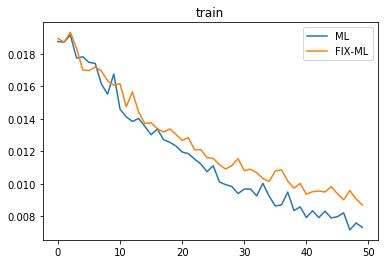

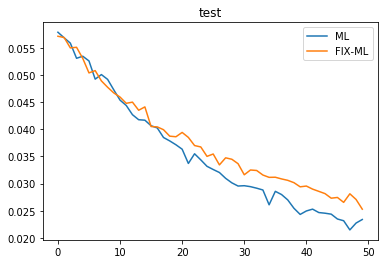

In [9]:
########### THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 50 # ambient dimension
k = 5 # actual subspace dimension of the weights (used in data generation)  
k_hat = 30 # subspace dimension we learn (used in prediction)
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
lr = 0.1 # learning rate for learning D
num_iterations_train = 1000000 # no of train_iterations
test_frequency = 20000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 9127

# Get Dataset
np.random.seed(seed)
X_pool = [X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device) for i in range(M)]
c_pool = [c_sample(k, distribution_sample=uniform_hypersphere, device=device) for i in range(T)]
Xq_pool = [X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device) for i in range(T)]


# obtain meta-learning and fix-meta learning solns
D_true = np.stack([isotropic_gaussian(d) for _ in range(k)], axis=0).T
D_true = np.linalg.qr(D_true)[0]
D_init = np.random.randn(d, k_hat)
D_test = D_true
# D_test = np.concatenate([D_true[:, :-1], np.random.randn(d, 1)], axis=1)

if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=False, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed) # reset seed to sample the same support and query sets through optimization
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, fixS=True, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [15]:
# retain only a subspace of the original span of D_true 
for p in range(1, 5):
    print('--'*50)
    print(p)
    D_test = np.concatenate([D_true[:, :-p], np.random.randn(d, p)], axis=1)
    print(D_test.shape)
    D = D_ML
    sum_test_loss = 0.
    n_test = 2000
    for i in range(n_test):
        X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
        Xq = X_sample(n=n2, d=d, distribution_sample=uniform_hypersphere, device=device)
        c = c_sample(k, distribution_sample=uniform_hypersphere, device=device)
        y = y_sample(D=D_test, c=c, X=X)
        yq = y_sample(D=D_test, c=c, X=Xq)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, X2=Xq, y2=yq, D=D, lambd=lambd, device=device)
        sum_test_loss += loss
    print("ML:", sum_test_loss / n_test)

    D = D_FIXML
    sum_test_loss = 0.
    n_test = 2000
    for i in range(n_test):
        X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
        Xq = X_sample(n=n2, d=d, distribution_sample=uniform_hypersphere, device=device)
        c = c_sample(k, distribution_sample=uniform_hypersphere, device=device)
        y = y_sample(D=D_test, c=c, X=X)
        yq = y_sample(D=D_test, c=c, X=Xq)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, X2=Xq, y2=yq, D=D, lambd=lambd, device=device)
        sum_test_loss += loss
    print("FIX ML:", sum_test_loss / n_test)

----------------------------------------------------------------------------------------------------
1
(50, 5)
ML: 1.0527954050308737
FIX ML: 1.0357819220999929
----------------------------------------------------------------------------------------------------
2
(50, 5)
ML: 1.2252217130837602
FIX ML: 1.2171355993270623
----------------------------------------------------------------------------------------------------
3
(50, 5)
ML: 2.1613445025395017
FIX ML: 2.0924224738068085
----------------------------------------------------------------------------------------------------
4
(50, 5)
ML: 2.814285837853607
FIX ML: 2.7442388796393926


In [16]:
"""
D is a matrix
X is a matrix
X2 is a matrix
c is a scalar
y is a vector
y2 is a vector
"""

from __future__ import division, print_function, absolute_import

import numpy as np

def fAndG(D, X, X2, c, y, y2):
    assert isinstance(D, np.ndarray)
    dim = D.shape
    assert len(dim) == 2
    D_rows = dim[0]
    D_cols = dim[1]
    assert isinstance(X, np.ndarray)
    dim = X.shape
    assert len(dim) == 2
    X_rows = dim[0]
    X_cols = dim[1]
    assert isinstance(X2, np.ndarray)
    dim = X2.shape
    assert len(dim) == 2
    X2_rows = dim[0]
    X2_cols = dim[1]
    if isinstance(c, np.ndarray):
        dim = c.shape
        assert dim == (1, )
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert isinstance(y2, np.ndarray)
    dim = y2.shape
    assert len(dim) == 1
    y2_rows = dim[0]
    assert y2_rows == X2_rows
    assert D_rows == X_cols == X2_cols
    assert y_rows == X_rows

    
    _, functionValue, gradient = task_c_loss_gradient_with_query(X, y, D, X2, y2, lambd=c)
    return functionValue, gradient

def checkGradient(D, X, X2, c, y, y2):
    # numerical gradient checking
    # f(x + t * delta) - f(x - t * delta) / (2t)
    # should be roughly equal to inner product <g, delta>
    t = 1E-6
    delta = np.random.randn(*D.shape)
    f1, _ = fAndG(D + t * delta, X, X2, c, y, y2)
    f2, _ = fAndG(D - t * delta, X, X2, c, y, y2)
    f, g = fAndG(D, X, X2, c, y, y2)
    print('approximation error',
          np.linalg.norm((f1 - f2) / (2*t) - np.tensordot(g, delta, axes=2)))

def generateRandomData():
    D = np.random.randn(30, 10)
    X = np.random.randn(5, 30)
    X2 = np.random.randn(100, 30)
    c = np.random.randn(1)
    y = np.random.randn(5)
    y2 = np.random.randn(100)

    return D, X, X2, c, y, y2

if __name__ == '__main__':
    D, X, X2, c, y, y2 = generateRandomData()
    functionValue, gradient = fAndG(D, X, X2, c, y, y2)
    print('functionValue = ', functionValue)
    print('gradient = ', gradient)

    print('numerical gradient checking ...')
    checkGradient(D, X, X2, c, y, y2)


functionValue =  66.34345874901544
gradient =  [[-8.13644307e-01  4.52775894e-01  5.75332503e+00 -2.36433506e+00
  -6.51429145e+00  5.89586220e+00  6.13556996e+00  7.55815651e+00
   3.32170937e+00 -1.02584167e+00]
 [ 2.73738036e-02 -5.91689874e-01 -4.66236286e+00  8.35425267e-01
   3.55974473e+00 -1.61537860e+00 -3.87032915e+00 -4.42884441e+00
  -1.80700308e+00  3.55609359e-01]
 [-1.31068788e-02 -1.34026814e-01 -1.00286339e+00  1.47220216e-01
   7.14017934e-01 -2.52412374e-01 -7.99383230e-01 -9.01655808e-01
  -3.62087605e-01  6.21928417e-02]
 [-2.22215475e+00 -2.25893396e-01  4.37559957e+00 -4.53959127e+00
  -9.31618695e+00  1.25072731e+01  7.46157535e+00  1.00512859e+01
   4.77110402e+00 -1.98706550e+00]
 [ 1.48542801e+00 -7.91662231e-02 -4.70922778e+00  3.33635628e+00
   7.56135190e+00 -8.92643607e+00 -6.45071033e+00 -8.38572976e+00
  -3.86618476e+00  1.45648690e+00]
 [ 9.33138623e-01  4.43305978e-01  8.63806760e-01  1.44938542e+00
   1.89283861e+00 -4.39557937e+00 -9.18601603e-01 -1